In [1]:
import os
import pywt
import glob
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

2024-07-05 14:52:14.766305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-05 14:52:17.949820: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Load data and preprocess

In [2]:
xTrain = np.load("./xTrain.npy")
yTrain = np.load("./yTrain.npy", allow_pickle=True)

xTest = np.load("./xTest.npy")
yTest = np.load("./yTest.npy", allow_pickle=True)

In [3]:
# Columns are:
#
# 0 = 'Beta_p'
# 1 = 'Va'
# 2 = 'Tratio'
# 3 = 'entropy'
# 4 = 'crossHelicity'
# 5 = 'residualEnergy'
# 6 = 'TotalPressure'
# 7 = 'bFluctuations'

In [3]:
# merge MO and SH into one class
ix0 = np.where( (yTrain == 0) | (yTrain == 4) )
yTrain[ix0[0]] = 0

In [4]:
# merge MO and SH into one class
ix0 = np.where( (yTest == 0) | (yTest == 4) )
yTest[ix0[0]] = 0

In [5]:
nClasses = len( np.unique( yTrain ) )
nClasses

4

In [7]:
y = tf.one_hot(yTrain,nClasses)

2024-06-21 15:37:05.658033: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5337 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:65:00.0, compute capability: 3.5


### Neural Network

In [8]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

In [7]:
def create_probablistic_bnn_model(rows,columns):
    
    inputs = tf.keras.layers.Input(shape=columns)
    
    hidden1 = tf.keras.layers.Dense(16, activation='relu')(inputs)    
    hidden2 = tf.keras.layers.Dense(8, activation='relu')(hidden1)
    
    distribution_params = layers.Dense(nClasses)(hidden2)
    outputs = tfp.layers.OneHotCategorical(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [8]:
def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)

In [11]:
bnn = create_probablistic_bnn_model(xTrain.shape[0],xTrain.shape[1])
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 one_hot_categorical (OneHot  ((None, 4),              0         
 Categorical)                 (None, 4))                         
                                                                 
Total params: 316
Trainable params: 316
Non-trainable params: 0
_______________________________________________________________

In [12]:
bnn.compile( loss=negative_loglikelihood, metrics=['accuracy'] )

In [13]:
history = bnn.fit( xTrain, y, epochs=200, verbose=1, 
                  use_multiprocessing=True, validation_split=0.2)

Epoch 1/200


2024-06-21 15:38:25.756604: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x718c1401fd80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-21 15:38:25.756676: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN Black, Compute Capability 3.5
2024-06-21 15:38:25.853105: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-21 15:38:27.151298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-06-21 15:38:27.346504: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-21 15:38:27.864415: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1225/1225 [==============================] - 74s 52ms/step - loss: 1.1016 - accuracy: 0.3797 - val_loss: 0.8860 - val_accuracy: 0.4881
Epoch 2/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.7780 - accuracy: 0.5422 - val_loss: 0.6816 - val_accuracy: 0.5858
Epoch 3/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.6166 - accuracy: 0.6250 - val_loss: 0.5574 - val_accuracy: 0.6563
Epoch 4/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.5231 - accuracy: 0.6832 - val_loss: 0.4950 - val_accuracy: 0.6990
Epoch 5/200
1225/1225 [==============================] - 61s 50ms/step - loss: 0.4721 - accuracy: 0.7139 - val_loss: 0.4775 - val_accuracy: 0.7234
Epoch 6/200
1225/1225 [==============================] - 61s 50ms/step - loss: 0.4395 - accuracy: 0.7359 - val_loss: 0.4227 - val_accuracy: 0.7485
Epoch 7/200
1225/1225 [==============================] - 60s 49ms/step - loss: 0.4136 - accuracy: 0.7509 - val_loss: 0.4177 - val_

1225/1225 [==============================] - 62s 51ms/step - loss: 0.0599 - accuracy: 0.9678 - val_loss: 0.0654 - val_accuracy: 0.9692
Epoch 112/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.0598 - accuracy: 0.9679 - val_loss: 0.0614 - val_accuracy: 0.9670
Epoch 113/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.0592 - accuracy: 0.9694 - val_loss: 0.0958 - val_accuracy: 0.9554
Epoch 114/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.0596 - accuracy: 0.9678 - val_loss: 0.0635 - val_accuracy: 0.9655
Epoch 115/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.0586 - accuracy: 0.9688 - val_loss: 0.0678 - val_accuracy: 0.9679
Epoch 116/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.0588 - accuracy: 0.9691 - val_loss: 0.0663 - val_accuracy: 0.9691
Epoch 117/200
1225/1225 [==============================] - 63s 51ms/step - loss: 0.0585 - accuracy: 0.9685 - val_loss: 0

1225/1225 [==============================] - 62s 51ms/step - loss: 0.0534 - accuracy: 0.9714 - val_loss: 0.0648 - val_accuracy: 0.9673
Epoch 167/200
1225/1225 [==============================] - 63s 51ms/step - loss: 0.0525 - accuracy: 0.9742 - val_loss: 0.0561 - val_accuracy: 0.9739
Epoch 168/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.0531 - accuracy: 0.9729 - val_loss: 0.0586 - val_accuracy: 0.9715
Epoch 169/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.0528 - accuracy: 0.9740 - val_loss: 0.0670 - val_accuracy: 0.9691
Epoch 170/200
1225/1225 [==============================] - 62s 51ms/step - loss: 0.0525 - accuracy: 0.9730 - val_loss: 0.0544 - val_accuracy: 0.9754
Epoch 171/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.0528 - accuracy: 0.9725 - val_loss: 0.0695 - val_accuracy: 0.9685
Epoch 172/200
1225/1225 [==============================] - 62s 50ms/step - loss: 0.0521 - accuracy: 0.9743 - val_loss: 0

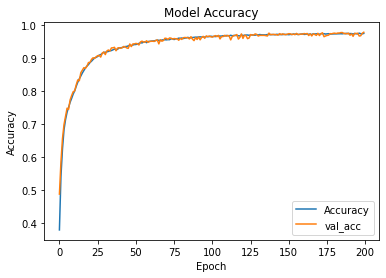

In [14]:
plt.plot( history.history['accuracy'], label="Accuracy")
plt.plot( history.history['val_accuracy'], label="val_acc")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

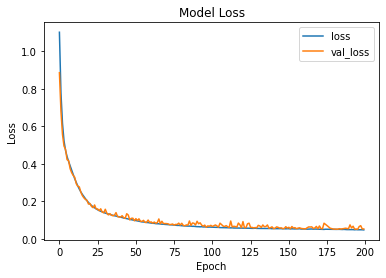

In [15]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [16]:
# serialize weights to HDF5
bnn.save_weights("./model_weights_8PNN_icme.h5")

In [17]:
from scipy.stats import entropy

preds = []
p = bnn( xTest )
en = bnn( xTest ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )
    
preds = np.array(preds)

In [23]:
font = {'weight' : 'bold', 'size'   : 20}
plt.rc('font', **font)

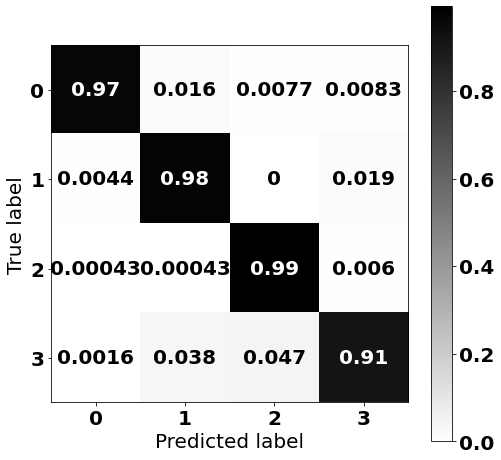

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 8))

cm = confusion_matrix( yTest.astype(int), preds, normalize='true' )
disp = ConfusionMatrixDisplay( confusion_matrix=cm )
disp.plot(ax=ax, cmap='gist_yarg')

In [25]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

yTest = yTest.astype(int)

print( "Macro F1:", np.round( f1_score(yTest, preds, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(yTest, preds, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(yTest, preds, average='macro'), 4 ))
print( "Accuracy:", np.round( accuracy_score(yTest, preds), 4 ))

Macro F1: 0.9591
Macro Precision: 0.9563
Macro Recall: 0.9629
Accuracy: 0.9636


### Load saved model

In [10]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

bnn = create_probablistic_bnn_model( xTest.shape[0], xTest.shape[1] )
 
# load weights into new model
bnn.load_weights("./model_weights_8PNN_icme.h5")

In [11]:
from scipy.stats import entropy

preds = []
p = bnn( xTest )
en = bnn( xTest ).entropy()

for i in range( p.shape[0] ):
    preds.append( np.argmax(p[i,:]) )